In [0]:
from __future__ import print_function
from numpy.random import seed
import numpy as np
import random
import tensorflow as tf

import os
os.environ['PYTHONHASHSEED'] = '0'
seed(30)
random.seed(235)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(928)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
print(hash("keras"))

Using TensorFlow backend.


-2849271805850266457


In [0]:
try:
    print('Importing dependencies...\n')
    import glob
    import nltk
    import warnings
    warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
    import gensim
    from gensim.models import Word2Vec
    from nltk.tokenize import WhitespaceTokenizer
    from numpy import array
    import time
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.initializers import Constant
    import multiprocessing as mp
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    from tensorflow.keras.models import load_model
    import logging

except:
    print('Failed to import dependencies.')
else:
    print('Successfully imported dependencies.')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1NhGJuRqZK7YpJlw8MdHU1WuE95wCKj_n' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  if f['title'] == 'trainHPOST-words.txt' :
    f = open(fname, 'r', encoding='utf-8')
    train_words = f.readlines()
    print(train_words[0])
  elif f['title'] == 'trainHPOST-tags.txt':
    f = open(fname, 'r', encoding='utf-8')
    train_tags = f.readlines()
    print(train_tags[0])
  elif f['title'] == 'testHPOST-words.txt':
    f = open(fname, 'r', encoding='utf-8')
    test_words = f.readlines()
    print(test_words[0])
  elif f['title'] == 'testHPOST-tags.txt':
    f = open(fname, 'r', encoding='utf-8')
    test_tags = f.readlines()
    print(test_tags[0])

Importing dependencies...

Successfully imported dependencies.
     |████████████████████████████████| 993kB 41.9MB/s 
title: trainHPOST-tags.txt, id: 1ADWjFbg_Dx0P7B61IYyqarfTLhj0f6P3
downloading to /root/data/trainHPOST-tags.txt
JJC VBS RBW PMC RBM VBOF DTC FW FW RBB FW FW CCA RBM VBOF DTC PMS FW PMS CCP NNC CCB JJD CCB JJCC JJD_CCP NNC JJC NNC PMP

title: testHPOST-tags.txt, id: 1yDRWvYLS0v3NBB-BS0TOUJf9G9Wvo7ty
downloading to /root/data/testHPOST-tags.txt
RBD_CCP JJCS_JJD DTC NNC CCB NNP FW PRO_CCP DTCP RBF JJD_CCP DTCP NNC PMP

title: testHPOST-words.txt, id: 1jlV7ytZU1UZkRtUuCnO6OqX3D4IqdbRU
downloading to /root/data/testHPOST-words.txt
Sobrang pinasimple ang kalkulasyon ng Roche limit nitong mga hindi makatotohanang mga pag-iisip .

title: trainHPOST-words.txt, id: 1HOkGBxaeewzw-7zhEEFuyLSxBjTNR8-e
downloading to /root/data/trainHPOST-words.txt
Katulad_ng nabanggit kanina , maaring gamitin ang wax cylinders para_sa home rekordings at maaring patugtugin ang “ indestructible ” na 

## Sentence Segmentation

In [0]:
print("\nTraining Set Words:\n\n", train_words[:2])
print("\nTraining Set Tags:\n\n", train_tags[:2])
print("\nTest Set Words:\n\n", test_words[:2])
print("\nTest Set Tags:\n\n", test_tags[:2])


Training Set Words:

 ['Katulad_ng nabanggit kanina , maaring gamitin ang wax cylinders para_sa home rekordings at maaring patugtugin ang “ indestructible ” na silindro ng paulit-ulit nang mas maraming beses kumpara_sa disk .\n', 'Dito rin matatagpuan ang South African Council_for_Scientific_and_Industrial_Research ( CSIR ) .\n']

Training Set Tags:

 ['JJC VBS RBW PMC RBM VBOF DTC FW FW RBB FW FW CCA RBM VBOF DTC PMS FW PMS CCP NNC CCB JJD CCB JJCC JJD_CCP NNC JJC NNC PMP\n', 'PRL RBI VBTF DTC NNP NNP NNP PMS NNPA PMS PMP \n']

Test Set Words:

 ['Sobrang pinasimple ang kalkulasyon ng Roche limit nitong mga hindi makatotohanang mga pag-iisip .\n', 'Ang sunog hindi maaring mabuhay nang wala ang lahat ng_mga elemento sa isang lugar .\n']

Test Set Tags:

 ['RBD_CCP JJCS_JJD DTC NNC CCB NNP FW PRO_CCP DTCP RBF JJD_CCP DTCP NNC PMP\n', 'DTC NNC RBF RBM VBW RBW RBF DTC PRI DTCP NNC CCT PRI_CCP NNC PMP\n']


## Tokenization

### Tokenization Function

In [0]:
def do_tokenization(data, list_name):
    tokenizer = WhitespaceTokenizer()
    datalist = []
    tokens = []
    print('\nTokenizing data...')
    start = time.time()
    for sentence in data:
        datalist.append(tokenizer.tokenize(sentence))
    end = time.time()
    print('Tokenization time: ', end - start, 'seconds.')
    max_sentence_len = 0
    for sentence in datalist:
        if max_sentence_len < len(sentence):
            max_sentence_len = len(sentence)
        for word in sentence:
            tokens.append(word)
    print('Max token sequence length:', max_sentence_len)
    print('Total number of sentences:', len(data))
    print('Total number of tokens:', len(tokens))
    list_name.extend(datalist)
    
train_words_list, train_tags_list, test_words_list, test_tags_list = [],[],[],[]

### Tokenization Process

In [0]:
do_tokenization(train_words, train_words_list)
do_tokenization(train_tags, train_tags_list)
do_tokenization(test_words, test_words_list)
do_tokenization(test_tags, test_tags_list)

train_sentences = [list(sentence) for sentence in train_words_list]
test_sentences = [array(sentence) for sentence in test_words_list]
train_tags = [array(sentence) for sentence in train_tags_list]
test_tags = [array(sentence) for sentence in test_tags_list]


Tokenizing data...
Tokenization time:  0.1256852149963379 seconds.
Max token sequence length: 161
Total number of sentences: 12133
Total number of tokens: 324899

Tokenizing data...
Tokenization time:  0.11166501045227051 seconds.
Max token sequence length: 161
Total number of sentences: 12133
Total number of tokens: 324899

Tokenizing data...
Tokenization time:  0.03290581703186035 seconds.
Max token sequence length: 137
Total number of sentences: 3033
Total number of tokens: 81610

Tokenizing data...
Tokenization time:  0.02873826026916504 seconds.
Max token sequence length: 137
Total number of sentences: 3033
Total number of tokens: 81610


## Word2Vec Model

### Declare Model Hyperparameters

In [0]:
cbow = 0
skipgram = 1
vector_dimensions = 300 #more dimensions, more computationally expensive to train
min_word_count = 1
workers = 1 #based on computer cpu count
context_size = 8
downsampling = 1e-3
negatives = 0 #for negative sampling
learning_rate = 0.03 #initial learning rate
min_learning_rate = 0.0001 #decayed learning rate
num_epoch = 10
seed = 1

### Set Model Hyperparameters

In [0]:
model = Word2Vec(
    sg = skipgram,
    #hs = 1, #hierarchical softmax
    size = vector_dimensions,
    min_count = min_word_count, 
    workers = workers,
    window = context_size, 
    negative = negatives,
    sample = downsampling,
    alpha = learning_rate, 
    min_alpha = min_learning_rate,
    seed = seed
)

### Show Model Hyperparameters

In [0]:
print('Model Architecture: Skipgram')
print('CPU count to build model:', workers)
print('Epochs:', num_epoch)
print('Initial Learning Rate:', learning_rate)
print('Learning rate will linearly drop to:', min_learning_rate)
print('Context Size:', context_size)
print('Vector Dimensions:', vector_dimensions, '\n')

Model Architecture: Skipgram
CPU count to build model: 1
Epochs: 10
Initial Learning Rate: 0.03
Learning rate will linearly drop to: 0.0001
Context Size: 8
Vector Dimensions: 300 



### Build Vocabulary for Word2Vec Model

In [0]:
try:
    print('Building Word2Vec model...\n')
    start = time.time()
    model.build_vocab(train_sentences)
    end = time.time()

except:
    print('Build unsuccessful.')

else:
    print('Build successful.')
    print('Build time', end - start, 'seconds.')
    print('Vocabulary size:', len(model.wv.vocab))

Building Word2Vec model...

Build successful.
Build time 0.8332614898681641 seconds.
Vocabulary size: 38125


### Train Word2Vec Model

In [0]:
print('Training model...')
start = time.time()
model.train(train_sentences, epochs = num_epoch, total_examples = model.corpus_count)
end = time.time()
logging.basicConfig(filename='word2vec_training.log', level=logging.DEBUG)
logging.debug(model.get_latest_training_loss())
print('Finished training in:', end - start, 'seconds.')

Training model...
Finished training in: 1.2882041931152344 seconds.


### Save Word2Vec Model

In [0]:
filename = 'W2Vmodel300con8ep10.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [0]:
upload = drive.CreateFile({'title': 'W2Vmodel300con8ep10.txt'})
upload.SetContentFile('W2Vmodel300con8ep10.txt')
upload.Upload()

## Create Embeddings Index

In [0]:
embeddings_index={}
f = open(os.path.join('','W2Vmodel300con8ep10.txt'), encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

print("Total:", len(embeddings_index.keys()), "keys\n")
print(embeddings_index.keys())

Total: 38126 keys

dict_keys(['38125', 'ng', 'na', ',', 'sa', 'ang', '.', 'at', 'ay', 'mga', 'isang', 'ng_mga', 'ang_mga', '(', ')', 'ito', 'Ang', 'ni', 'noong', 'si', 'hindi', 'may', 'bilang', 'kanyang', 'kung', '“', 'Sa', 'para_sa', '”', 'o', 'mas', '"', 'upang', 'pa', 'nito', 'mula_sa', 'saan', 'siya', 'rin', 'kanilang', 'Noong', '-', 'niya', 'naging', 'kasama', 'hanggang', 'para', ';', 'ibang', 'taon', 'tao', 'pang', 'lamang', 'unang', 'ngunit', 'isa', 'panahon', 'ilang', 'din', 'sa_pamamagitan_ng', 'lungsod', 'iba', 'taong', 'lahat', 'maraming', 'bahagi', 'tulad_ng', 'dalawang', 'dahil_sa', 'sila', ':', 'bansa', 'walang', 'habang', 'Ang_mga', 'pangunahing', 'nang', 'nila', 'lugar', 'siglo', 'kahit', 'bagong', 'buong', '%', 'naman', 'malaking', 'maaaring', 'itong', 'pagkatapos', 'dahil', 'mayroong', 'Isang', 'uri', 'tinatawag', 'bawat', 'kay', 'karamihan', 'ngayon', 'maging', 'pangalan', 'ginagamit', 'buhay', 'populasyon', 'gamit', 'parehong', 'lang', 'araw', 'kaysa_sa', 'dito', 's

## Build Vocabulary

### Show Training Vocabulary Counts

In [0]:
word_list, tag_list = set([]), set([])

for sentence_word in train_sentences:
    for word in sentence_word:
        word_list.add(word)
        
for sentence_tag in train_tags:
    for tag in sentence_tag:
        tag_list.add(tag)
        
print("Number of unique words:", len(word_list))
print("Number of unique tags:", len(tag_list))

Number of unique words: 38125
Number of unique tags: 211


## Word to Integer, Tag to Integer

### Word to Integer Dictionary

In [0]:
word_to_int = {word: i + 2 for i, word in enumerate(list(word_list))}

### Add PAD to Word to Integer Dictionary

In [0]:
word_to_int['PAD'] = 0 #for padding

### Add WORD-OOV  to Word to Integer Dictionary

In [0]:
word_to_int['WORD-OOV'] = 1 #for out-of-vocabulary words

### Tag to Integer Dictionary

In [0]:
tag_to_int = {tag: i + 1 for i, tag in enumerate(list(tag_list))}

### Add PAD to Tag to Integer Dictionary

In [0]:
tag_to_int['PAD'] = 0 #for padding

### Add TAG-OOV to Tag to Integer Dictionary

In [0]:
tag_to_int['TAG-OOV'] = 1

### Word and Tag Dictionary Count

In [0]:
print("Word Dictionary contains: ", len(word_to_int), "words.")
print("Tag Dictionary contains: ", len(tag_to_int), "tags.")

Word Dictionary contains:  38127 words.
Tag Dictionary contains:  213 tags.


## Build Embedding Matrix

In [0]:
num_words = len(word_to_int)+1
embedding_matrix = np.zeros((num_words, vector_dimensions)) #38128 , 300
print(word_to_int)
for word, i in word_to_int.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print("Number of embeddings in the embedding matrix:", len(embedding_matrix), "\n")
print("Embedding matrix:\n", embedding_matrix, "\n")
print("A single element in the embedding matrix:\n", embedding_matrix[500])

{'nakasasama': 2, 'Pio': 3, 'Iminumungkahi': 4, 'Anton': 5, 'kompleho': 6, 'pagkompetensiya': 7, 'tamad': 8, 'pakikipanayam': 9, 'Story': 10, 'Tanakh': 11, 'Bilang_sagot': 12, 'ikinabibilangan': 13, 'Po': 14, 'Portuguese': 15, 'Interim': 16, 'Kaba': 17, 'Tangway': 18, 'Sinuporta': 19, 'kinaya': 20, 'nagpahinto': 21, 'posporus': 22, 'Noong': 23, 'ipatungkol': 24, 'prinisipe': 25, 'Primetime': 26, 'infraredradiation': 27, 'matandang': 28, 'golden': 29, 'ikinansel': 30, 'Euclidean': 31, 'Romance': 32, 'Americo': 33, 'Brigade_of_Marines': 34, 'saykayatryang': 35, 'Paget': 36, 'Nababatid': 37, 'Gagno': 38, 'panalo': 39, 'chimpanzees': 40, 'roaring': 41, 'Hoyert': 42, 'Kido': 43, 'pumalibot': 44, 'Nadiyagnos': 45, 'bastas': 46, 'spider': 47, 'Flynnville': 48, 'semantikong': 49, 'kondisyon': 50, 'CSIR': 51, 'matibay': 52, 'nakapwesto': 53, 'kinailangan': 54, 'analytical': 55, 'Diagnostic_and_Statistical_Manual_of_Mental_Disorders': 56, 'Pula': 57, 'droplets': 58, 'pinapalamig': 59, 'tatlumpun

In [0]:
np.save('embedding_matrix', embedding_matrix)

In [0]:
upload = drive.CreateFile({'title': 'embedding_matrix.npy'})
upload.SetContentFile('embedding_matrix.npy')
upload.Upload()

In [0]:
import pickle
worddict = word_to_int
tagdict = tag_to_int
f = open("word_to_int.pkl","wb")
pickle.dump(worddict,f)
f.close()
f = open("tag_to_int.pkl","wb")
pickle.dump(tagdict,f)
f.close()

In [0]:
pickle_word_dict = open("word_to_int.pkl","rb")
word_dict = pickle.load(pickle_word_dict)
print(word_dict)

{'nakasasama': 2, 'Pio': 3, 'Iminumungkahi': 4, 'Anton': 5, 'kompleho': 6, 'pagkompetensiya': 7, 'tamad': 8, 'pakikipanayam': 9, 'Story': 10, 'Tanakh': 11, 'Bilang_sagot': 12, 'ikinabibilangan': 13, 'Po': 14, 'Portuguese': 15, 'Interim': 16, 'Kaba': 17, 'Tangway': 18, 'Sinuporta': 19, 'kinaya': 20, 'nagpahinto': 21, 'posporus': 22, 'Noong': 23, 'ipatungkol': 24, 'prinisipe': 25, 'Primetime': 26, 'infraredradiation': 27, 'matandang': 28, 'golden': 29, 'ikinansel': 30, 'Euclidean': 31, 'Romance': 32, 'Americo': 33, 'Brigade_of_Marines': 34, 'saykayatryang': 35, 'Paget': 36, 'Nababatid': 37, 'Gagno': 38, 'panalo': 39, 'chimpanzees': 40, 'roaring': 41, 'Hoyert': 42, 'Kido': 43, 'pumalibot': 44, 'Nadiyagnos': 45, 'bastas': 46, 'spider': 47, 'Flynnville': 48, 'semantikong': 49, 'kondisyon': 50, 'CSIR': 51, 'matibay': 52, 'nakapwesto': 53, 'kinailangan': 54, 'analytical': 55, 'Diagnostic_and_Statistical_Manual_of_Mental_Disorders': 56, 'Pula': 57, 'droplets': 58, 'pinapalamig': 59, 'tatlumpun

In [0]:
pickle_tag_dict = open("tag_to_int.pkl","rb")
tag_dict = pickle.load(pickle_tag_dict)
print(tag_dict)

{'CCT_LM': 1, 'RBI_CCA': 2, 'PRP_CCB': 3, 'VBTF_CCP': 4, 'NNP_CCP': 5, 'VBW': 6, 'VBTR_VBOF_CCP': 7, 'RBR_DTP': 8, 'JJCS_VBTR_VBOF': 9, 'JJCS_VBN_CCP': 10, 'VBOF': 11, 'RBQ': 12, 'VBTS_CCA': 13, 'RBK': 14, 'JJCS_JJC': 15, 'CDB_LM': 16, 'RBT': 17, 'RBL_JJD_CCP': 18, 'RBS': 19, 'RBD_CCB': 20, 'NNC': 21, 'PRI': 22, 'CDB_NNC': 23, 'JJCS_VBAF': 24, 'PRS': 25, 'RBD_LM': 26, 'RBL_NNPA': 27, 'PRI_CCT': 28, 'VBN': 29, 'RBL_JJD': 30, 'JJC_CCP': 31, 'PRC_CCP': 32, 'VBTR_VBRF_CCP': 33, 'VBS': 34, 'PRS_LM': 35, 'VBTR_VBOF': 36, 'JJN_CCB': 37, 'JJD_CCP': 38, 'VBTS_VBAF': 39, 'CDB': 40, 'VBTS_VBOF_CCP': 41, 'VBH_CCB': 42, 'VBS_CCP': 43, 'RBS_CCP': 44, 'VBTR_VBOB': 45, 'CCT_CCP': 46, 'JJD_CCT': 47, 'PRI_CCP_NNP': 48, 'CCR': 49, 'RBF_JJD': 50, 'PRQ_LM': 51, 'RBF_CCP': 52, 'RBT_LM': 53, 'RBD_CCP': 54, 'VBTS_VBOB': 55, 'VBOB_CCP': 56, 'JJN_CCA': 57, 'VBTF_VBOF': 58, 'PRO': 59, 'VBTR': 60, 'CCT_CCA': 61, 'RBR': 62, 'VBTR_VBRF': 63, 'VBTR_VBAF_CCP': 64, 'RBW_DTP': 65, 'RBW_RBI': 66, 'JJCS_JJD': 67, 'RBF': 

In [0]:
upload = drive.CreateFile({'title': 'word_to_int.pkl'})
upload.SetContentFile('word_to_int.pkl')
upload.Upload()
upload = drive.CreateFile({'title': 'tag_to_int.pkl'})
upload.SetContentFile('tag_to_int.pkl')
upload.Upload()

## Integer Conversion

In [0]:
x_train, y_train, x_test, y_test = [], [], [], []

for sentence in train_sentences:
    sentence_word_int = []
    for word in sentence:
        try:
            sentence_word_int.append(word_to_int[word])
        except KeyError:
            sentence_word_int.append(word_to_int['WORD-OOV'])
            
    x_train.append(sentence_word_int)
    
for sentence in test_sentences:
    sentence_word_int = []
    for word in sentence:
        try:
            sentence_word_int.append(word_to_int[word])
        except KeyError:
            sentence_word_int.append(word_to_int['WORD-OOV'])
            
    x_test.append(sentence_word_int)
    
for sentence_tag in train_tags:
    y_train.append([tag_to_int[tag] for tag in sentence_tag])
    
for sentence_tag in test_tags:
	#y_test.append([tag_to_int[tag] for tag in sentence_tag])
    sentence_tag_int = []
    for tag in sentence_tag:
        try:
            sentence_tag_int.append(tag_to_int[tag])
        except KeyError:
            sentence_tag_int.append(tag_to_int['TAG-OOV'])
    y_test.append(sentence_tag_int)

print("Train Words:", "\n", x_train[0], "\n")
print("Train Tags:", "\n", y_train[0], "\n")
print("Test Words:", "\n", x_test[0], "\n")
print("Test Tags:", "\n", y_test[0])

Train Words: 
 [658, 14600, 19663, 7867, 26493, 28976, 23809, 23728, 13693, 1280, 21327, 1426, 5154, 26493, 17651, 23809, 3330, 21627, 21760, 36037, 31269, 16899, 18876, 10081, 17620, 1864, 25151, 15125, 14092, 20702] 

Train Tags: 
 [91, 34, 203, 145, 166, 11, 126, 157, 157, 110, 157, 157, 87, 166, 11, 126, 95, 157, 95, 90, 21, 183, 78, 183, 107, 38, 21, 91, 21, 146] 

Test Words: 
 [7641, 5322, 23809, 17859, 16899, 37446, 15560, 11542, 27714, 26336, 30221, 27714, 8435, 20702] 

Test Tags: 
 [54, 67, 126, 21, 183, 182, 157, 209, 69, 68, 38, 69, 21, 146]


In [0]:
f = open("x_train.pkl","wb")
pickle.dump(x_train,f)
f.close()
f = open("y_train.pkl","wb")
pickle.dump(y_train,f)
f.close()
f = open("x_test.pkl","wb")
pickle.dump(x_test,f)
f.close()
f = open("y_test.pkl","wb")
pickle.dump(y_test,f)
f.close()

In [0]:
upload = drive.CreateFile({'title': 'x_train.pkl'})
upload.SetContentFile('x_train.pkl')
upload.Upload()
upload = drive.CreateFile({'title': 'y_train.pkl'})
upload.SetContentFile('y_train.pkl')
upload.Upload()
upload = drive.CreateFile({'title': 'x_test.pkl'})
upload.SetContentFile('x_test.pkl')
upload.Upload()
upload = drive.CreateFile({'title': 'y_test.pkl'})
upload.SetContentFile('y_test.pkl')
upload.Upload()

In [0]:
pickle_x_train = open("x_train.pkl","rb")
x_train = pickle.load(pickle_x_train)
print(x_train[0])

pickle_y_train = open("y_train.pkl","rb")
y_train = pickle.load(pickle_y_train)
print(y_train[0])

pickle_x_test = open("x_test.pkl","rb")
x_test = pickle.load(pickle_x_test)
print(x_test[0])

pickle_y_test = open("y_test.pkl","rb")
y_test = pickle.load(pickle_y_test)
print(y_test[0])

[658, 14600, 19663, 7867, 26493, 28976, 23809, 23728, 13693, 1280, 21327, 1426, 5154, 26493, 17651, 23809, 3330, 21627, 21760, 36037, 31269, 16899, 18876, 10081, 17620, 1864, 25151, 15125, 14092, 20702]
[91, 34, 203, 145, 166, 11, 126, 157, 157, 110, 157, 157, 87, 166, 11, 126, 95, 157, 95, 90, 21, 183, 78, 183, 107, 38, 21, 91, 21, 146]
[7641, 5322, 23809, 17859, 16899, 37446, 15560, 11542, 27714, 26336, 30221, 27714, 8435, 20702]
[54, 67, 126, 21, 183, 182, 157, 209, 69, 68, 38, 69, 21, 146]


## Sequence Padding

### Show Max Length of Sentences

In [0]:
sent_max_length = len(max(x_train, key=len))
print(sent_max_length)

161


### Pad Sequences of Sentences

In [0]:
x_train = pad_sequences(x_train, maxlen=sent_max_length, padding="post")
x_test = pad_sequences(x_test, maxlen=sent_max_length, padding="post")
y_train = pad_sequences(y_train, maxlen=sent_max_length, padding="post")
y_test = pad_sequences(y_test, maxlen=sent_max_length, padding="post")

print(x_train[0])
print(y_train[0])
print(x_test[0])
print(y_test[0])

[  658 14600 19663  7867 26493 28976 23809 23728 13693  1280 21327  1426
  5154 26493 17651 23809  3330 21627 21760 36037 31269 16899 18876 10081
 17620  1864 25151 15125 14092 20702     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[ 91  34 203 145 16

### Define F1 Score Function

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2*p*r / (p+r)

    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

## BLSTM Model

### Import Keras Dependencies

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Activation, Dropout

### Model Creation

In [0]:
def create_model():
  model = Sequential()
  embedding_layer=Embedding(num_words, vector_dimensions, embeddings_initializer=Constant(embedding_matrix), input_length=sent_max_length, trainable=True, mask_zero=True)
  model.add(InputLayer(input_shape=(sent_max_length, )))
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(len(tag_to_int))))
  model.add(Activation('softmax'))

  opt = tf.train.AdamOptimizer(0.0005)

  model.compile(loss='categorical_crossentropy', 
                optimizer=opt,
                metrics=['accuracy', f1])
  
  return model

model = create_model()
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 161, 300)          11438400  
_________________________________________________________________
bidirectional (Bidirectional (None, 161, 256)          439296    
_________________________________________________________________
dropout (Dropout)            (None, 161, 256)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 161, 213)          54741     
_________________________________________________________________
activation (Activation)      (None, 161, 213)          0         
Total params: 11,932,437
Trainable params: 11,932,437
Non-trainable params: 0
_________

## One-hot Encoding of Training Tags

### To One-hot Function

In [0]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

### Show One-hot Example

In [0]:
y_train_tags = to_categorical(y_train, len(tag_to_int))
print(y_train_tags[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Train BLSTM Model

### Add Early Stopping

In [0]:
es_val_acc = EarlyStopping(monitor="val_acc", mode="max", verbose=1, patience=3, min_delta=0.02)
es_val_loss = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

### Add Model Checkpoint

In [0]:
filepath = "blstm-model-weights-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_weights_only=True, save_best_only=True, mode="max")

### Create Callback

In [0]:
callback_list = [checkpoint]

## Train Model

In [0]:
history = model.fit(x_train, to_categorical(y_train, len(tag_to_int)), batch_size=1024, epochs=100, validation_data=(x_test, to_categorical(y_test, len(tag_to_int))), callbacks=callback_list)
scores = model.evaluate(x_test, to_categorical(y_test, len(tag_to_int)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")
print(model.metrics_names)
print(scores)

Train on 12133 samples, validate on 3033 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
11264/12133 [==========================>...] - ETA: 0s - loss: 5.3337 - acc: 0.1353 - f1: 0.0000e+00
Epoch 00001: val_acc improved from -inf to 0.13609, saving model to blstm-model-weights-01-0.1361.h5
12133/12133 [==============================] - 14s 1ms/sample - loss: 5.3292 - acc: 0.1358 - f1: 0.0000e+00 - val_loss: 5.2487 - val_acc: 0.1361 - val_f1: 0.0000e+00
Epoch 2/100
11264/12133 [==========================>...] - ETA: 0s - loss: 4.8613 - acc: 0.1372 - f1: 3.9809e-06
Epoch 00002: val_acc did not improve from 0.13609
12133/12133 [==============================] - 12s 993us/sample - loss: 4.8082 - acc: 0.1366 - f1: 9.9376e-06 - val_loss: 3.9573 - val_acc: 0.1361 - val_f1: 3.7436e-04
Epoch 3/100
11264/12133 [==========================>...] - ETA: 0s - loss: 3.8536 - acc: 0.1229 - f1: 1.5001e-04
E

In [0]:
upload = drive.CreateFile({'title': 'model.h5'})
upload.SetContentFile('blstm-model-weights-64-0.9183.h5')
upload.Upload()

## Visualization of Model Metrics

### Plot Training and Testing Accuracy Values

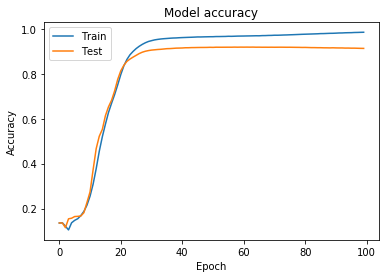

In [0]:
plt.figure()
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("acc.png")

### Plot Training and Testing Loss Values

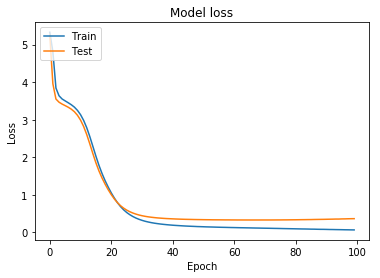

In [0]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss.png")

### Plot Training and Testing F1 Score Values

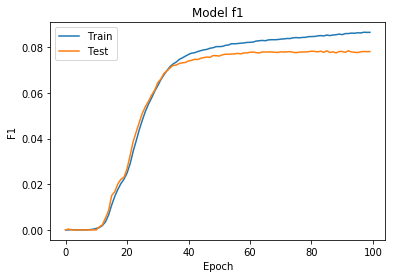

In [0]:
plt.figure()
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("f1.png")

### Show Graphs

In [0]:
plt.show()

In [0]:
upload = drive.CreateFile({'title': 'acc.png'})
upload.SetContentFile('acc.png')
upload.Upload()
upload = drive.CreateFile({'title': 'loss.png'})
upload.SetContentFile('loss.png')
upload.Upload()
upload = drive.CreateFile({'title': 'f1.png'})
upload.SetContentFile('f1.png')
upload.Upload()

In [0]:
another_model = create_model()
another_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 161, 300)          11438400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 161, 256)          439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 161, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 161, 213)          54741     
_________________________________________________________________
activation_1 (Activation)    (None, 161, 213)          0         
Total params: 11,932,437
Trainable params: 11,932,437
Non-trainable params: 0
_________________________________________________________________


In [0]:
another_model.load_weights('blstm-model-weights-64-0.9183.h5')

In [0]:
test_scores = another_model.evaluate(x_test, to_categorical(y_test, len(tag_to_int)), batch_size=2048)
print(f"{another_model.metrics_names[1]}: {test_scores[1] * 100}")
print(another_model.metrics_names)
print(test_scores)

3033/3033 [==============================] - 2s 542us/sample - loss: 0.3303 - acc: 0.9183 - f1: 0.0894
acc: 91.83188080787659
['loss', 'acc', 'f1']
[0.3302769983144943, 0.9183188, 0.089394994]
